# Import Keras, H5py, Numpy

In [1]:
from __future__ import print_function
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import RepeatVector,Reshape
from keras import backend as K
import h5py
import numpy as np

path = 'C:\\Users\\user\\university\\year3\\sem6\\tcg172\\'
batch_size = 128
num_classes = 10
epochs = 3


Using TensorFlow backend.


# Segmentation Data Initialization

In [2]:
# load data from NPZ file
all_data = np.load(path+'mnist_points_segmentation.npz')
all_data.keys()
# #test arrays
train_labels = all_data['train_labels']
train_data = all_data['train_data']
#validation arrays
valid_labels = all_data['valid_labels']
valid_data = all_data['valid_data']
#test arrays
test_labels = all_data['test_labels']
test_data = all_data['test_data']
#seg data
train_seg_labels = all_data['train_seg']
valid_seg_labels = all_data['valid_seg']
test_seg_labels = all_data['test_seg']
train_data = train_data.astype('float32')
valid_data = valid_data.astype('float32')
test_data = test_data.astype('float32')
train_data = train_data.reshape(train_data.shape[0],1,200,2)
valid_data = valid_data.reshape(valid_data.shape[0],1,200,2)
test_data = test_data.reshape(test_data.shape[0],1,200,2)
print('test_data shape: ',test_data.shape)
print('test_labels shape: ',test_labels.shape)
print('test_seg_labels shape: ',test_seg_labels.shape)

test_data shape:  (10000, 1, 200, 2)
test_labels shape:  (10000,)
test_seg_labels shape:  (10000, 200)


# One Hot Encoding for 200*2 labels

In [3]:
# in each label, all first 100 are the digit and the rest are background so we can easily 1 hot encode them
seg_label = np.empty([200,2])
for j in range(0,100):
    seg_label[j]=[1,0]
for j in range(100,200):
    seg_label[j]=[0,1]
# print(encoded_train_labels)
encoded_valid_labels= np.empty([10000,200,2])
for i in range(0,10000):
    encoded_valid_labels[i]=seg_label
encoded_test_labels= np.empty([10000,200,2])
for i in range(0,10000):
    encoded_test_labels[i]=seg_label 
encoded_train_labels= np.empty([50000,200,2])
for i in range(0,50000):
    encoded_train_labels[i]=seg_label 
print('created labels')
print('encoded_test_labels shape: ',encoded_test_labels.shape)

created labels
encoded_test_labels shape:  (10000, 200, 2)


# Segmentation functional model

In [4]:
segmentation_inputs = Input(shape=(1,200,2))

#implement 2X2 TNET here

segLayer1 = Conv2D(64,(1,1),strides=1, activation='relu')(segmentation_inputs)
segLayer2 = Conv2D(64,(1,1), strides=1, activation='relu')(segLayer1)

#missing 64X64 TNET here

localFeatures = Conv2D(64,(1,1), strides=1, activation='relu')(segLayer2)

segLayer4 = Conv2D(128,(1,1), strides=1, activation='relu')(localFeatures)
segLayer5 = Conv2D(1024,(1,1), strides=1, activation='relu')(segLayer4)

#max pooling layer
segLayer6 = MaxPooling2D((1,200), strides=1, padding='valid')(segLayer5)
segLayer7 = Flatten()(segLayer6)

#merge local and global features into one vector
segLayer8 = RepeatVector(200)(segLayer7)

globalFeatures = Reshape((1,200,1024))(segLayer8)
mixedFeatures = keras.layers.concatenate([localFeatures,globalFeatures])
print('local and global features shape: ',mixedFeatures._keras_shape)

# second MLP
segLayer11 = Conv2D(512,(1,1), strides=1, activation='relu')(mixedFeatures)
segLayer12 = Conv2D(256,(1,1), strides=1, activation='relu')(segLayer11)
pointFeatures = Conv2D(128,(1,1), strides=1, activation='relu')(segLayer12)
# pointFeatures = Reshape((200,128))(pointFeatures)
# print("point features: ",pointFeatures._keras_shape)

# third MLP

segLayer14 = Conv2D(128,(1,1), strides=1, activation='relu')(pointFeatures)
predictions = Conv2D(2,(1,1), strides=1, activation='softmax')(segLayer14)
predictions = Reshape((200,2))(predictions)


segmentation_model = Model(inputs= segmentation_inputs, outputs= predictions)
segmentation_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


local and global features shape:  (None, 1, 200, 1088)


In [ ]:
segmentation_model.summary()

# Training the model

In [9]:
segmentation_model.fit(train_data,encoded_train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_data, encoded_valid_labels))
score = segmentation_model.evaluate(test_data,encoded_test_labels, verbose=0)
    
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2367s - loss: 0.1272 - acc: 0.9499 - val_loss: 0.0925 - val_acc: 0.9649
Epoch 2/3
50000/50000 [==============================] - 2359s - loss: 0.0899 - acc: 0.9661 - val_loss: 0.0965 - val_acc: 0.9631
Epoch 3/3
50000/50000 [==============================] - 2224s - loss: 0.0771 - acc: 0.9718 - val_loss: 0.0675 - val_acc: 0.9753
Test loss: 0.0647749237716
Test accuracy: 0.976459500694


In [10]:
# segmentation_model.save_weights('seg_model.h5py')

In [5]:
segmentation_model.load_weights('seg_model.h5py')

# Visualization: Show predictions on requested class

In [6]:
from matplotlib import pyplot as plt

In [19]:
def front_and_back(data_arr,index,labels,ispred):
    j=0
    k=0
    number = np.empty([200,2])
    background = np.empty([200,2])
    for i in range(0,200):
        if ispred:
            cur_pred = labels[0][i]
        else:
            cur_pred = labels[index][i]
        if cur_pred[0]>cur_pred[1]:
            background[j]=data_arr[index][0][i]
            j=j+1
        else:
            number[k]=data_arr[index][0][i]
            k=k+1
    n = number[:k]
    b = background[:j]
    return n,b

def intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected = np.intersect1d(arr1_view, arr2_view)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1])   

# Analysis of a digit (for the report) - visualize some data

please enter a digit from 0 to 9: 6


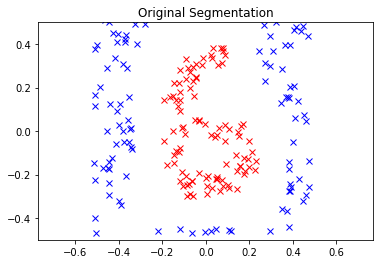

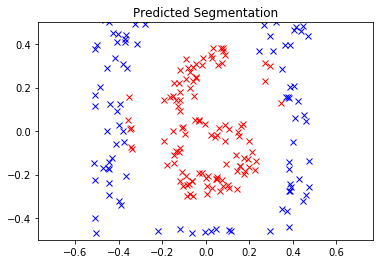

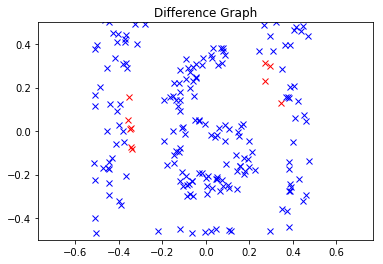

In [25]:
digit = int(input('please enter a digit from 0 to 9: '))

visualization_data = np.empty([1,1,200,2])
c=0
for i in range(0,10000):
    if test_labels[i]==digit:
        visualization_data[0]=test_data[i]
        vis_label=i
        c=c+1
        if c==2:
            break

front,back = front_and_back(test_data,vis_label,encoded_test_labels,0)
plt.title('Original Segmentation')
plt.plot(back[:-1,0],back[:-1,1],'xr')
plt.plot(front[:-1,0],front[:-1,1],'xb')
plt.axis('equal')
plt.axis([-0.5,0.5,-0.5,0.5])
plt.show()

preds= segmentation_model.predict(visualization_data)
p_front,p_back = front_and_back(test_data,vis_label,preds,1)
plt.title('Predicted Segmentation')
plt.plot(p_back[:-1,0],p_back[:-1,1],'xr')
plt.plot(p_front[:-1,0],p_front[:-1,1],'xb')
plt.axis('equal')
plt.axis([-0.5,0.5,-0.5,0.5])
plt.show()

front_correct = intersect(front,p_front)
back_correct = intersect(back,p_back)
front_wrong = np.array(list(set(tuple(x) for x in front).difference(tuple(x) for x in p_front)))
back_wrong = np.array(list(set(tuple(x) for x in back).difference(tuple(x) for x in p_back)))

plt.title('Difference Graph')
plt.plot(front_correct[:-1,0],front_correct[:-1,1],'xb')
plt.plot(back_correct[:-1,0],back_correct[:-1,1],'xb')
if front_wrong.size!=0:
    plt.plot(front_wrong[:-1,0],front_wrong[:-1,1],'xr')
if back_wrong.size!=0:
    plt.plot(back_wrong[:-1,0],back_wrong[:-1,1],'xr')
plt.axis('equal')
plt.axis([-0.5,0.5,-0.5,0.5])
plt.show()

# per class accuracy

In [7]:
classes_preds= segmentation_model.predict(test_data)


In [15]:
def get_classes_acc(preds,digits,true_labels):
    total = np.zeros(10)
    hits = np.zeros(10)
    for i in range(0,10000):
        digit = digits[i]
        total[digit]=total[digit]+200
        true_lab = true_labels[i]
        pred_lab = preds[i]
        for j in range(0,200):
            p = pred_lab[j] #preds for 0 or 1 (back or front)
            if (true_lab[j]==0 and p[0]>p[1]) or (true_lab[j]==1 and p[1]>p[0]):
                hits[digit] = hits[digit]+1
    hits = hits/total
    hits = hits*100
    return hits

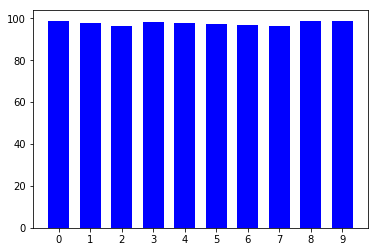

[ 98.81530612  97.98370044  96.08333333  98.02821782  97.86812627
  97.31390135  96.70824635  96.31420233  98.83932238  98.51833499]


In [17]:
class_accuracies = get_classes_acc(classes_preds,test_labels,test_seg_labels)
x = np.arange(10)
width= 1/1.5
plt.bar(x,class_accuracies,width,color='blue')
plt.xticks(x)
plt.show()
print(class_accuracies)

# Visualization for the report: ratio of errors in predicting background points vs errors of predicting digit points in an input

In [36]:
def errors_back_vs_front(seg_preds,seg_true_preds,labels,digit):
    back_errors = 0
    front_errors = 0
    sum_errors = 0
    for i in range(0,10000):
        if labels[i]==digit:
            cur_pred = seg_preds[i]
            cur_true = seg_true_preds[i]
            for j in range(0,200):
                vals = cur_pred[j]
                if (vals[0]>vals[1] and cur_true[j]==1):
                    back_errors = back_errors+1
                    sum_errors = sum_errors+1
                elif (vals[1]>vals[0] and cur_true[j]==0):
                    front_errors = front_errors+1
                    sum_errors= sum_errors+1
    return (back_errors/sum_errors),(front_errors/sum_errors)
# return percents of background errors, percents of digit errors
            

In [39]:
def per_class_back_vs_front_errors(preds,seg_labs,test_labs):
    back_errors= np.empty(10)
    front_errors = np.empty(10)
    for i in range(0,10):
        background_err_rate, digit_err_rate =  errors_back_vs_front(preds,seg_labs,test_labs,i)
        back_errors[i]=background_err_rate
        front_errors[i]=digit_err_rate
    return back_errors*100,front_errors*100

In [42]:
back_errors, front_errors = per_class_back_vs_front_errors(classes_preds,test_seg_labels,test_labels)

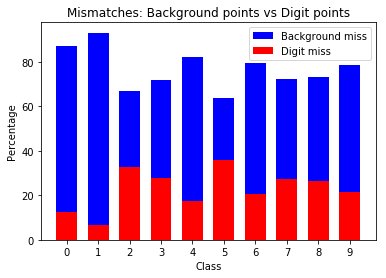

avg back and front:  76.9849860507 23.0150139493


In [46]:
x= np.arange(10)
width = 1/1.5
plt.bar(x,back_errors,width,color='blue',label='Background miss')
plt.bar(x,front_errors,width,color='red',label = 'Digit miss')
plt.title('Mismatches: Background points vs Digit points')
plt.xticks(x)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.legend()
plt.show()
print('avg back and front: ',sum(back_errors)/10,sum(front_errors)/10)

In [48]:
print(back_errors,front_errors)

[ 87.42463394  93.20515622  67.15734785  72.13155913  82.32624791
  63.87729549  79.35627081  72.51253629  73.33038479  78.52842809] [ 12.57536606   6.79484378  32.84265215  27.86844087  17.67375209
  36.12270451  20.64372919  27.48746371  26.66961521  21.47157191]
